# 📊 CFPB Consumer Complaints EDA

## 📦 About the Dataset
The **Consumer Financial Protection Bureau (CFPB)** collects and publishes thousands of consumer complaints each week regarding financial products and services.  
Each complaint is routed to the relevant company, and the company’s responses are tracked. By making this dataset public, the CFPB aims to improve **transparency and accountability** in the U.S. financial marketplace.

- **Source:** [CFPB Consumer Complaints Database](https://www.consumerfinance.gov/data-research/consumer-complaints/)  
- **Columns include:**  
  - `date_received`, `product`, `sub_product`, `issue`, `sub_issue`, `company`, `state`, `company_response_to_consumer`, `timely_response`, etc.  
  - Contains categorical, textual, and timestamp fields  
- **Typical size:** 2M+ rows  

---

## 🎯 Project Goal
To explore the U.S. consumer complaint landscape and generate **actionable insights** for companies, regulators, and consumers through large-scale exploratory data analysis.

---

## 🛠️ Methods & Workflow
1. **Data Cleaning & Preparation**  
   - Handle missing or inconsistent values  
   - Standardize product, issue, and company names  
   - Parse and enrich dates (year, month, quarter, weekday)  
   - Optimize processing for scale (`pandas` with chunking, `dask`, or `polars`)

2. **Exploratory Data Analysis (EDA)**  
   - **Time Trends:** complaint volume over time (monthly/annual)  
   - **Categorical Breakdown:** by product, sub-product, issue, company, and state  
   - **Company Behavior:** response types, timeliness, and closure patterns  
   - **Geographic Patterns:** state-level complaint distribution  
   - **Text Exploration:** keyword frequency, topic clustering, sentiment analysis (consumer narratives)

3. **Visualization**  
   - Time series (line plots)  
   - Categorical breakdowns (bar charts, treemaps)  
   - Geographic distribution (choropleth maps, heatmaps)  
   - Text visuals (wordclouds, keyword networks, topic clusters)

4. **Business & Consumer Insights**  
   - Identify recurring issues by product or company  
   - Detect emerging trends and seasonal patterns  
   - Compare best- and worst-performing companies on response KPIs  
   - Highlight potential targets for regulatory attention

---

## 🔍 Key Questions with Statistics → Visualization → KPI

### 1. Which products and companies receive the most complaints?
- **Statistics:** frequency counts of complaints by product/company  
- **Visualization:** bar chart (top-N), time-series trend by top products/companies  
- **KPI:**  
  - Complaint share of top products/companies (%)  
  - MoM/YoY growth rates  



### 2. What issues and sub-issues are most frequent?
- **Statistics:** frequency counts of issues/sub-issues  
- **Visualization:** bar chart of top issues, heatmap of product × issue  
- **KPI:**  
  - Top issues by share (%)  
  - Cross-tab ratios (e.g., % of complaints for issue X within product Y)  



### 3. How have complaint volumes changed over time?
- **Statistics:** monthly/annual counts  
- **Visualization:** line plots of trends, rolling averages  
- **KPI:**  
  - Trend slope (complaints per month)  
  - MoM/YoY growth rates  



### 4. Are there geographic hotspots by state?
- **Statistics:** state-level frequency counts  
- **Visualization:** bar chart (top states), choropleth/heatmap  
- **KPI:**  
  - Share of top states (%)  
  - (Optional) normalized complaints per 100k residents  



### 5. How do companies differ in timely responses and resolution patterns?
- **Statistics:** response-type counts, timely-response averages by company  
- **Visualization:** bar chart (timely% by company), stacked bars (response mix), time-series (monthly timely%)  
- **KPI:**  
  - % timely responses (overall & by company)  
  - Resolution/closure rates  



### 6. What do consumer narratives reveal about sentiment and root causes?
- **Statistics:** keyword counts, topic distributions from narratives  
- **Visualization:** wordclouds, keyword frequency bar charts, topic maps  
- **KPI:**  
  - Top keywords/phrases  
  - Topic prevalence  
  - Sentiment polarity scores  

---

## 💡 Expected Outcomes
- **For Companies:** clear signals on areas to improve service and communication  
- **For Regulators:** evidence-based prioritization of oversight and enforcement  
- **For Consumers:** transparency on which companies and products attract the most complaints  
- **For Portfolio:** demonstration of skills in data cleaning, EDA, visualization, and **storytelling at scale**

---

## 📝 Author
**Minhyeok Son**  
[LinkedIn](https://www.linkedin.com/in/minhyeokson) | [GitHub](https://github.com/Shawn-Son)

In [52]:
# =========================================
# 1) Setup & Imports
# =========================================
import os
import re
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Pandas display options (for convenience in EDA)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
pd.set_option("display.max_rows", 30)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Data path
DATA_PATH = '../../Datasets/finance/consumer_complaints.csv'

In [53]:
# =========================================
# 2) Load Data (as requested path)
#    - For large CSVs, low_memory=False avoids mixed dtypes
# =========================================
df = pd.read_csv(DATA_PATH, low_memory=False)
print(df.shape)
df.head(3)

(555957, 18)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473


In [54]:
# =========================================
# 3) Standardize Column Names to snake_case
#    - Example: "Date received" -> "date_received"
#    - Remove special characters
# =========================================
def to_snake(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^\w\s]", " ", s)   # non-word chars -> space
    s = re.sub(r"\s+", "_", s)       # spaces -> underscore
    return s

df.columns = [to_snake(c) for c in df.columns]
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state',
       'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response',
       'consumer_disputed_', 'complaint_id'],
      dtype='object')

In [55]:
# =========================================
# 4) Check for Key Columns (dataset versions vary)
#    - This prevents breaking when some columns are missing
# =========================================
expected_cols = [
    "complaint_id", "date_received", "product", "sub_product",
    "issue", "sub_issue", "company", "state", "zip_code",
    "submitted_via", "date_sent_to_company", "company_response_to_consumer",
    "timely_response", "company_public_response", "consumer_disputed",
    "consumer_complaint_narrative"
]
present = [c for c in expected_cols if c in df.columns]
missing = [c for c in expected_cols if c not in df.columns]
print("Present:", present)
print("Missing:", missing)

Present: ['complaint_id', 'date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'company', 'state', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'company_public_response', 'consumer_complaint_narrative']
Missing: ['zip_code', 'consumer_disputed']


In [56]:
# =========================================
# 5) Parse Date Columns (coerce errors to NaT)
# =========================================
date_cols = [c for c in ["date_received", "date_sent_to_company"] if c in df.columns]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")
df[date_cols].dtypes if date_cols else "no date columns"

date_received           datetime64[ns]
date_sent_to_company    datetime64[ns]
dtype: object

In [57]:
# =========================================
# 6) Basic Cleaning for Categorical-like Columns
#    - strip whitespace
#    - normalize casing
#    - state to uppercase; product/issue to title-case
# =========================================
cat_like = [
    "product", "sub_product", "issue", "sub_issue",
    "company", "state", "submitted_via",
    "company_response_to_consumer", "company_public_response",
    "timely_response", "consumer_disputed"
]
for c in cat_like:
    if c in df.columns and df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip()

if "state" in df.columns:
    df["state"] = df["state"].str.upper()

for c in ["product", "sub_product", "issue", "sub_issue", "submitted_via"]:
    if c in df.columns:
        df[c] = df[c].str.replace(r"\s+", " ", regex=True)
        df[c] = df[c].str.title()

df.head(3)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed_,complaint_id
0,2013-08-30,Mortgage,Other Mortgage,"Loan Modification,Collection,Foreclosure",Nan,NaN,nan,U.S. Bancorp,CA,95993,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511074
1,2013-08-30,Mortgage,Other Mortgage,"Loan Servicing, Payments, Escrow Account",Nan,NaN,nan,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511080
2,2013-08-30,Credit Reporting,Nan,Incorrect Information On Credit Report,Account Status,NaN,nan,Wells Fargo & Company,NY,11764,NaN,NaN,Postal Mail,2013-09-18,Closed with explanation,Yes,No,510473


In [58]:
# =========================================
# 7) Memory Optimization
#    - Convert low-cardinality object columns to category
#    - Downcast numeric columns
# =========================================
def optimize_memory(frame: pd.DataFrame, cat_threshold=0.6):
    df_opt = frame.copy()
    for col in df_opt.columns:
        if df_opt[col].dtype == "object":
            nunique = df_opt[col].nunique(dropna=True)
            ratio = nunique / max(len(df_opt), 1)
            if ratio < cat_threshold:
                df_opt[col] = df_opt[col].astype("category")
        elif pd.api.types.is_integer_dtype(df_opt[col]):
            df_opt[col] = pd.to_numeric(df_opt[col], downcast="integer")
        elif pd.api.types.is_float_dtype(df_opt[col]):
            df_opt[col] = pd.to_numeric(df_opt[col], downcast="float")
    return df_opt

before = df.memory_usage(deep=True).sum() / 1024**2
df = optimize_memory(df, cat_threshold=0.6)
after = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory (MB): {before:.1f} -> {after:.1f}")

Memory (MB): 525.3 -> 94.7


In [59]:
# =========================================
# 8) Deduplicate on complaint_id (if present)
# =========================================
if "complaint_id" in df.columns:
    dup_count = df.duplicated(subset=["complaint_id"]).sum()
    print("Duplicates on complaint_id:", dup_count)
    df = df.drop_duplicates(subset=["complaint_id"])
else:
    print("complaint_id not found; skipping de-duplication.")

Duplicates on complaint_id: 0


In [60]:
# =========================================
# 9) Time Features (year, month, year_month)
# =========================================
if "date_received" in df.columns:
    df["year"] = df["date_received"].dt.year
    df["month"] = df["date_received"].dt.month
    df["year_month"] = df["date_received"].dt.to_period("M").astype(str)
else:
    print("date_received not found; skipping time features.")
df[["date_received","year","month","year_month"]].head(3) if "date_received" in df.columns else df.head(1)

,date_received,year,month,year_month
0,2013-08-30,2013,8,2013-08
1,2013-08-30,2013,8,2013-08
2,2013-08-30,2013,8,2013-08


In [61]:
# =========================================
# 10) Missingness Overview (top 20 by NA rate)
# =========================================
na_rate = df.isna().mean().sort_values(ascending=False).to_frame("na_rate")
na_rate.head(20)

,na_rate
consumer_complaint_narrative,0.879836
tags,0.859775
consumer_consent_provided,0.777936
zipcode,0.008103
submitted_via,0.000000
month,0.000000
year,0.000000
complaint_id,0.000000
consumer_disputed_,0.000000
timely_response,0.000000


In [62]:
# =========================================
# 11) Basic Range & Size Info
# =========================================
print("Rows:", len(df))
if "date_received" in df.columns:
    print("Date range:", df["date_received"].min(), "->", df["date_received"].max())

Rows: 555957
Date range: 2011-12-01 00:00:00 -> 2016-04-25 00:00:00


In [63]:
# Helpers for shares, growth, ranking with minimum volume thresholds
from typing import Optional

def add_share(df_cnt, total=None, col_name="share_%"):
    total = total if total is not None else df_cnt.sum()
    out = (df_cnt / total * 100).round(2)
    return pd.DataFrame({"count": df_cnt, col_name: out})

def month_index(df, date_col="date_received"):
    s = df.set_index(date_col).resample("MS").size()
    return s

def top_with_growth(df, key_col, date_col="date_received", top_n=10, min_months=6):
    # top by total count
    totals = df[key_col].value_counts().head(top_n).index
    sub = df[df[key_col].isin(totals)].copy()
    sub = sub.dropna(subset=[date_col])
    # monthly counts per key
    m = (sub.set_index(date_col)
             .groupby(key_col)
             .resample("MS")
             .size()
             .rename("count")
             .reset_index())
    # aggregate totals & share
    agg = sub[key_col].value_counts()
    out = add_share(agg, total=agg.sum(), col_name="share_%")
    # MoM and YoY for the latest month per key
    latest = m.groupby(key_col).apply(lambda x: x.sort_values(date_col).tail(13)).reset_index(drop=True)
    def growth_last(x):
        x = x.sort_values(date_col)
        if len(x) < 2:
            mom = np.nan
        else:
            mom = (x["count"].iloc[-1] - x["count"].iloc[-2]) / max(x["count"].iloc[-2], 1) * 100
        if len(x) < 13:
            yoy = np.nan
        else:
            yoy = (x["count"].iloc[-1] - x["count"].iloc[-13]) / max(x["count"].iloc[-13], 1) * 100
        return pd.Series({"MoM_%": round(mom, 2), "YoY_%": round(yoy, 2)})
    gr = latest.groupby(key_col).apply(growth_last)
    out = out.join(gr, how="left")
    return out.sort_values("count", ascending=False)

def slope_trend(series: pd.Series):
    """Return simple linear trend slope (per month) on index-ordered series."""
    y = series.values.astype(float)
    x = np.arange(len(y))
    if len(x) < 2:
        return np.nan
    slope = np.polyfit(x, y, 1)[0]
    return slope

def league_table_ratio(df, group_col, flag_col, min_count=500):
    g = df.groupby(group_col)[flag_col].agg(["mean","count"]).rename(columns={"mean":"ratio"})
    g = g[g["count"] >= min_count].copy()
    g["ratio_%"] = (g["ratio"]*100).round(2)
    return g.sort_values("ratio", ascending=False)

# Q1. Which products get the most complaints?

In [64]:
if "product" in df.columns:
    prod_top = top_with_growth(df.dropna(subset=["product"]), key_col="product", date_col="date_received", top_n=15)
    display(prod_top.head(15))
else:
    print("product not found.")

/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(key_col)
/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:22: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()
/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

,count,share_%,MoM_%,YoY_%
product,,,,
Mortgage,186475,33.54,-64.32,-62.00
Debt Collection,101052,18.18,-57.31,-57.24
Credit Reporting,91854,16.52,-43.41,-15.51
Credit Card,66468,11.96,-55.90,-49.89
Bank Account Or Service,62563,11.25,-64.91,-59.85
Consumer Loan,20990,3.78,-54.64,-37.94
Student Loan,15839,2.85,-50.42,-58.74
Payday Loan,3877,0.70,-58.33,-67.86
Money Transfers,3812,0.69,-51.16,-51.91


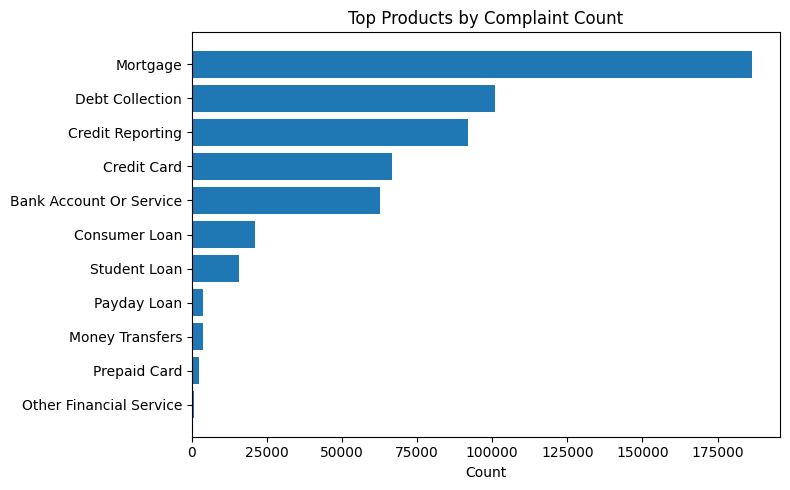

In [65]:
if "product" in df.columns:
    vc = df["product"].value_counts().head(15).sort_values()
    plt.figure(figsize=(8,5))
    plt.barh(vc.index.astype(str), vc.values)
    plt.title("Top Products by Complaint Count")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

**Products with highest complaint volume.**
- Top products: **{A}, {B}, {C}** (covering ~**{share}%** of all complaints).
- Recent dynamics: **{Top1}** shows **MoM {mom1}%** and **YoY {yoy1}%** change (latest month).
- Interpretation: 집중 관리가 필요한 제품은 **{focus_product}** (높은 점유 + 최근 증가). 안정세는 **{stable_product}**.
- Action: 상위 1~2개 제품에 대해 **상세 이슈 분해** 및 **회사별 대응 비교** 진행.

# Q2. What issues/sub-issues are most common?

In [66]:
if "issue" in df.columns:
    issue_top = add_share(df["issue"].value_counts().head(20))
    display(issue_top.head(20))
else:
    print("issue not found.")

,count,share_%
issue,,
"Loan Modification,Collection,Foreclosure",97191,21.33
Incorrect Information On Credit Report,66718,14.64
"Loan Servicing, Payments, Escrow Account",60375,13.25
Cont'D Attempts Collect Debt Not Owed,42285,9.28
"Account Opening, Closing, Or Management",26661,5.85
Communication Tactics,18293,4.01
Disclosure Verification Of Debt,18292,4.01
Deposits And Withdrawals,17195,3.77
"Application, Originator, Mortgage Broker",13306,2.92


In [67]:
# Issue x Product matrix (top)
if {"issue","product"}.issubset(df.columns):
    top_issues = df["issue"].value_counts().head(10).index
    top_prods  = df["product"].value_counts().head(6).index
    issue_prod = pd.crosstab(
        df[df["issue"].isin(top_issues)]["issue"],
        df[df["product"].isin(top_prods)]["product"]
    )
    display(issue_prod)

product,Bank Account Or Service,Credit Card,Credit Reporting,Debt Collection,Mortgage
issue,,,,,
"Account Opening, Closing, Or Management",26661,0,0,0,0
"Application, Originator, Mortgage Broker",0,0,0,0,13306
Billing Disputes,0,11042,0,0,0
Communication Tactics,0,0,0,18293,0
Cont'D Attempts Collect Debt Not Owed,0,0,0,42285,0
Deposits And Withdrawals,17195,0,0,0,0
Disclosure Verification Of Debt,0,0,0,18292,0
Incorrect Information On Credit Report,0,0,66718,0,0
"Loan Modification,Collection,Foreclosure",0,0,0,0,97191


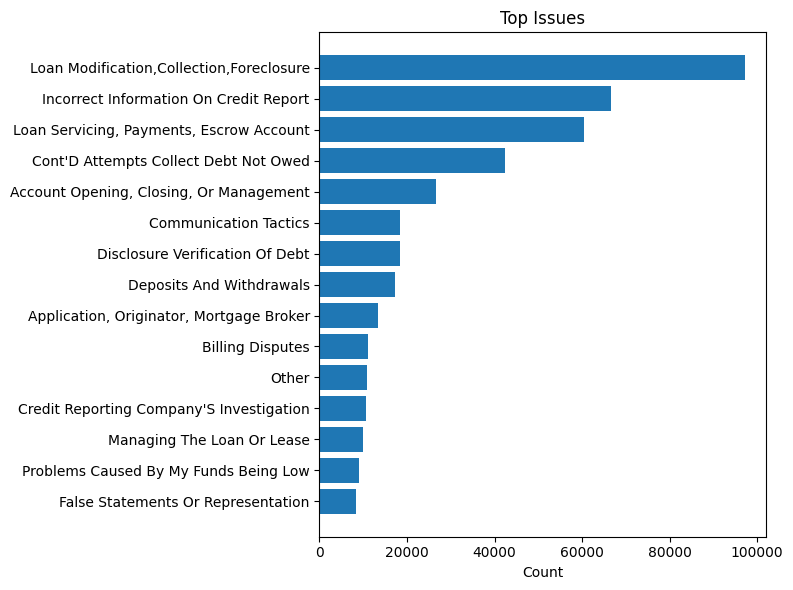

In [68]:
if "issue" in df.columns:
    vc = df["issue"].value_counts().head(15).sort_values()
    plt.figure(figsize=(8,6))
    plt.barh(vc.index.astype(str), vc.values)
    plt.title("Top Issues")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

**Most frequent issues.**
- Top issues: **{I1}, {I2}, {I3}** (≈ **{share_I}%** combined).
- Product-issue linkage: **{issue_x}** is concentrated in **{product_y}** (see crosstab).
- Interpretation: 규정 위반/약관 설명 부족/프로세스 지연 등 **원인 가설**을 제시하고 검증 계획 수립.
- Action: 상위 이슈에 대한 **FAQ/프로세스 개선** 또는 **알림 문구 개선** 제안.

# Q3. Which companies have the highest volume?

In [69]:
if "company" in df.columns:
    comp_top = top_with_growth(df.dropna(subset=["company"]), key_col="company", date_col="date_received", top_n=20)
    display(comp_top.head(20))
else:
    print("company not found.")

/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(key_col)
/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:22: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()
/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

,count,share_%,MoM_%,YoY_%
company,,,,
Bank of America,55998,15.30,-61.58,-60.27
Wells Fargo & Company,42024,11.48,-64.44,-55.04
JPMorgan Chase & Co.,33881,9.26,-59.71,-51.88
Equifax,31828,8.69,-40.38,-7.88
Experian,30905,8.44,-45.89,-24.67
Citibank,25540,6.98,-59.80,-53.49
"TransUnion Intermediate Holdings, Inc.",25534,6.98,-42.10,-11.59
Ocwen,20978,5.73,-64.64,-70.55
Capital One,15628,4.27,-58.63,-52.40


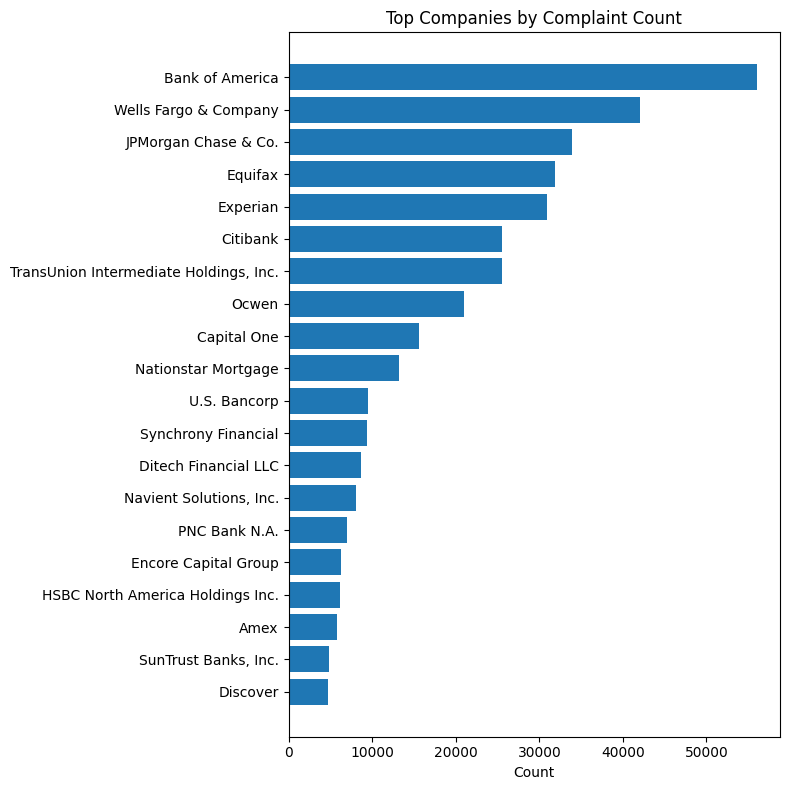

In [70]:
if "company" in df.columns:
    vc = df["company"].value_counts().head(20).sort_values()
    plt.figure(figsize=(8,8))
    plt.barh(vc.index.astype(str), vc.values)
    plt.title("Top Companies by Complaint Count")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

**High-complaint companies.**
- Top by volume: **{C1}, {C2}, {C3}**.
- Trend: **{C1}** MoM **{mom1}%**, YoY **{yoy1}%** (volume-based).
- Caution: 시장 점유/고객 수 미반영. 향후 **per-customer** 또는 **per-account** 기준 지표 확보 필요.
- Action: 상위 회사의 **응답 유형/Timely%** 비교로 서비스 차이 진단.

# Q4. How do response rates and response types differ?

In [71]:
if {"company","timely_response"}.issubset(df.columns):
    sub = df.dropna(subset=["company"])
    sub["is_timely"] = (sub["timely_response"].astype(str).str.lower() == "yes").astype(int)
    timely_league = league_table_ratio(sub, "company", "is_timely", min_count=1000)
    display(timely_league.head(10))   # best
    display(timely_league.tail(10))   # worst
else:
    print("Required columns missing.")

/var/folders/vs/dy5n5y354mz0k83z44gbr5ph0000gn/T/ipykernel_57338/1617028098.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_col)[flag_col].agg(["mean","count"]).rename(columns={"mean":"ratio"})


,ratio,count,ratio_%
company,,,
"Portfolio Recovery Associates, Inc.",1.000000,3387,100.00
Synchrony Financial,1.000000,9435,100.00
BBVA Compass,1.000000,1016,100.00
Transworld Systems Inc.,1.000000,1456,100.00
"TransUnion Intermediate Holdings, Inc.",1.000000,25534,100.00
Flagstar Bank,1.000000,1712,100.00
Equifax,1.000000,31828,100.00
"Navient Solutions, Inc.",0.999875,8007,99.99
Experian,0.999806,30905,99.98


,ratio,count,ratio_%
company,,,
PNC Bank N.A.,0.984371,6974,98.44
M&T Bank Corporation,0.982848,2507,98.28
"Diversified Consultants, Inc.",0.981922,1051,98.19
"Carrington Mortgage Holdings, LLC.",0.981627,1143,98.16
Ocwen,0.974306,20978,97.43
Bank of America,0.972285,55998,97.23
USAA Savings,0.967697,2167,96.77
"Bayview Loan Servicing, LLC",0.964209,1397,96.42
Regions Financial Corporation,0.951613,2232,95.16


In [72]:
if {"company","company_response_to_consumer"}.issubset(df.columns):
    top10 = df["company"].value_counts().head(10).index
    sub = df[df["company"].isin(top10)]
    resp_tab = pd.crosstab(sub["company"], sub["company_response_to_consumer"], normalize="index").round(3)
    display(resp_tab)

company_response_to_consumer,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Closed with relief,Closed without relief,In progress,Untimely response
company,,,,,,,,
Bank of America,0.017,0.665,0.079,0.136,0.015,0.081,0.004,0.002
Capital One,0.011,0.644,0.160,0.084,0.025,0.073,0.003,0.000
Citibank,0.005,0.615,0.184,0.108,0.027,0.053,0.005,0.004
Equifax,0.001,0.750,0.001,0.240,0.000,0.000,0.008,0.000
Experian,0.004,0.547,0.013,0.413,0.000,0.000,0.022,0.000
JPMorgan Chase & Co.,0.017,0.759,0.096,0.039,0.024,0.059,0.005,0.000
Nationstar Mortgage,0.024,0.941,0.002,0.013,0.000,0.009,0.010,0.000
Ocwen,0.052,0.870,0.008,0.019,0.006,0.043,0.002,0.000
"TransUnion Intermediate Holdings, Inc.",0.001,0.736,0.004,0.250,0.000,0.000,0.009,0.000


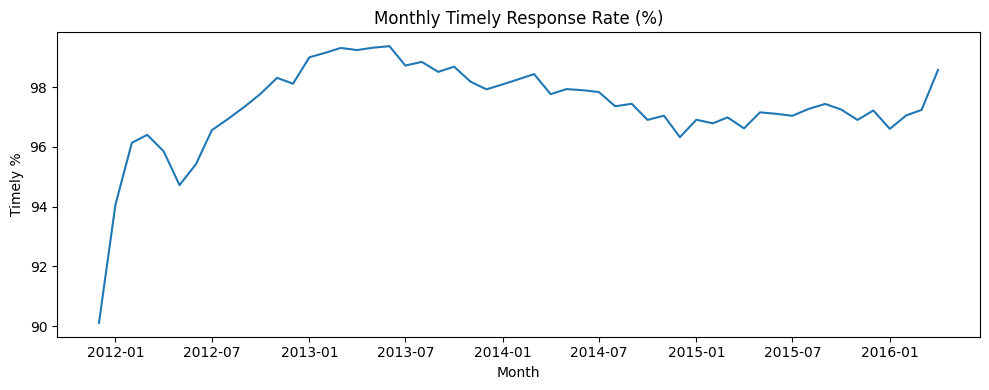

In [73]:
if {"date_received","timely_response"}.issubset(df.columns):
    m = df.dropna(subset=["date_received"]).copy()
    m["is_timely"] = (m["timely_response"].astype(str).str.lower() == "yes").astype(int)
    ts = m.set_index("date_received").resample("MS")["is_timely"].mean()*100
    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values)
    plt.title("Monthly Timely Response Rate (%)")
    plt.xlabel("Month")
    plt.ylabel("Timely %")
    plt.tight_layout()
    plt.show()

**Response behavior differences.**
- Timely% best performers (n≥1k): **{B1} {b1}%**, **{B2} {b2}%** …  
- Timely% worst performers (n≥1k): **{W1} {w1}%**, **{W2} {w2}%** …
- Response-type mix: **{comp_x}** has higher **{type_a}** share vs peers (see table), implying **{implication}**.
- Trend: Overall Timely% is **{level}%**, with slope **{slope} per month** (improving/declining).
- Action: 저성과 회사에 대해 **SLA/프로세스 병목** 점검 권고.

In [74]:
if {"date_received","timely_response"}.issubset(df.columns):
    trend_slope = slope_trend(ts.dropna())
    trend_slope

# Q5. Are there geographic patterns?

In [75]:
if "state" in df.columns:
    st = add_share(df["state"].value_counts())
    display(st.head(20))
else:
    print("state not found.")

,count,share_%
state,,
CA,81700,14.70
FL,53673,9.65
TX,41352,7.44
NY,38266,6.88
GA,24548,4.42
NJ,22408,4.03
PA,20015,3.60
IL,19624,3.53
VA,18150,3.26


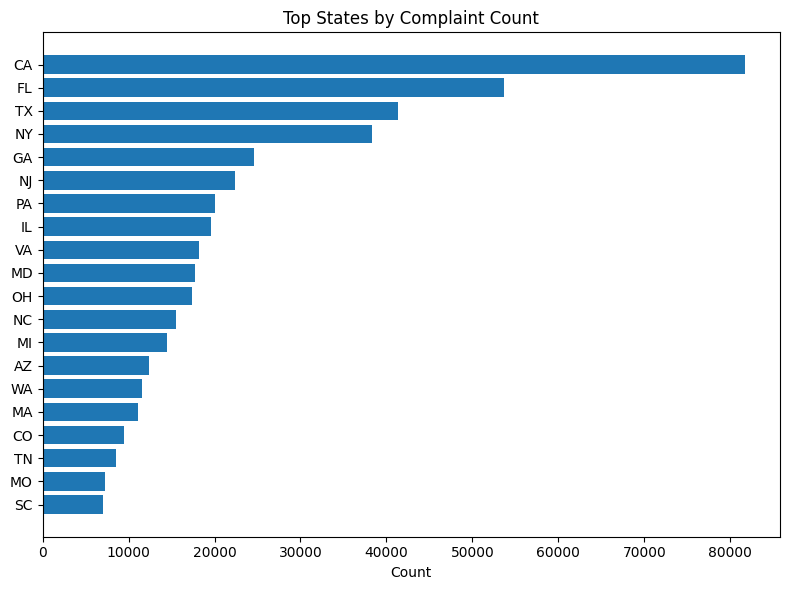

In [76]:
if "state" in df.columns:
    vc = df["state"].value_counts().head(20).sort_values()
    plt.figure(figsize=(8,6))
    plt.barh(vc.index.astype(str), vc.values)
    plt.title("Top States by Complaint Count")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

**Geographic patterns.**
- Highest complaint states: **{S1}, {S2}, {S3}** (combined **{share}%**).
- Interpretation: 인구 규모/금융상품 보급률/특정 이벤트(법·정책 변화) 고려 필요.  
- Action: 상위 주에서 **제품/이슈 분해**하여 원인 파악(예: 특정 주의 특정 이슈 집중).

# Q6. Has volume increased/decreased over time?

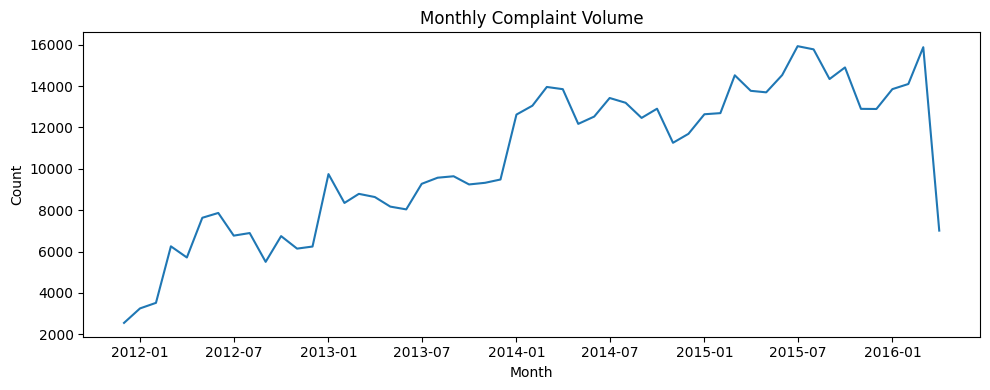

6-month rolling mean (tail):


date_received
2015-05-01    13170.666667
2015-06-01    13644.166667
2015-07-01    14193.000000
2015-08-01    14707.166667
2015-09-01    14677.000000
2015-10-01    14865.666667
2015-11-01    14732.500000
2015-12-01    14459.333333
2016-01-01    14113.000000
2016-02-01    13833.666667
2016-03-01    14090.333333
2016-04-01    12774.833333
Freq: MS, dtype: float64

Linear trend slope (count per month): 197.02


In [77]:
if "date_received" in df.columns:
    monthly = month_index(df, "date_received")
    plt.figure(figsize=(10,4))
    plt.plot(monthly.index, monthly.values)
    plt.title("Monthly Complaint Volume")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Rolling mean & slope
    roll = monthly.rolling(6, min_periods=3).mean()
    slope = slope_trend(monthly.dropna())
    print("6-month rolling mean (tail):")
    display(roll.tail(12))
    print("Linear trend slope (count per month):", round(slope, 2))

**Trend over time.**
- Peak periods: **{peak_months}** with **{peak_count}** complaints.
- 6-month rolling: 최근 **{direction}** (상승/하락/횡보).
- Linear slope: **{slope}** complaints/month (positive = increasing trend).
- Action: 피크 구간 전후로 **제품/이슈 구성 변화** 비교(전후 3개월 윈도우).

In [78]:
kpi = {}
kpi["rows"] = int(len(df))

if "date_received" in df.columns:
    kpi["date_min"] = df["date_received"].min()
    kpi["date_max"] = df["date_received"].max()
    monthly = month_index(df, "date_received")
    kpi["trend_slope_cnt_per_month"] = round(slope_trend(monthly.dropna()), 2)

if "product" in df.columns:
    kpi["top_products"] = df["product"].value_counts().head(5).to_dict()
if "issue" in df.columns:
    kpi["top_issues"] = df["issue"].value_counts().head(5).to_dict()
if "company" in df.columns:
    kpi["top_companies"] = df["company"].value_counts().head(5).to_dict()
if "state" in df.columns:
    kpi["top_states"] = df["state"].value_counts().head(5).to_dict()
if "timely_response" in df.columns:
    kpi["timely_rate_%"] = round((df["timely_response"].astype(str).str.lower() == "yes").mean()*100, 2)
if "company_response_to_consumer" in df.columns:
    kpi["resp_mix_%"] = (df["company_response_to_consumer"].value_counts(normalize=True)*100).round(2).to_dict()

pd.Series(kpi, dtype="object")

rows                                                                    555957
date_min                                                   2011-12-01 00:00:00
date_max                                                   2016-04-25 00:00:00
trend_slope_cnt_per_month                                               197.02
top_products                 {'Mortgage': 186475, 'Debt Collection': 101052...
top_issues                   {'Loan Modification,Collection,Foreclosure': 9...
top_companies                {'Bank of America': 55998, 'Wells Fargo & Comp...
top_states                   {'CA': 81700, 'FL': 53673, 'TX': 41352, 'NY': ...
timely_rate_%                                                            97.47
resp_mix_%                   {'Closed with explanation': 72.72, 'Closed wit...
dtype: object

**KPI Summary.**
- Coverage: **{rows} rows**, period **{date_min} → {date_max}**.
- Volume trend slope: **{slope}** complaints/month (**↑/↓/→**).
- Top products/issues/companies/states: 요약 테이블 참조.
- Timely response rate: **{timely}%**; response mix shows **{top_response_type}** dominant.
- Next: 상위 카테고리 교차분석과 저성과 회사 SLA 점검 제안.